In [1]:
#!pip install langchain langchain-openai
#!pip install langgraph

In [2]:

from langgraph.graph import StateGraph, END
from typing import TypedDict, List
from langchain_core.messages import HumanMessage, AIMessage
from langchain_openai import ChatOpenAI
from typing import TypedDict, List, Dict


In [3]:
import os
import getpass

if "OPENAI_API_KEY" not in os.environ:
    os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter your OpenAI API key: ")

Enter your OpenAI API key:  ········


In [4]:
from langchain_core.prompts import PromptTemplate

In [5]:
from langchain_openai import ChatOpenAI
# Initialize the ChatOpenAI model
llm = ChatOpenAI(
    model_name="gpt-4o",  # Specify the model (e.g., gpt-4, gpt-3.5-turbo)
    temperature=0.7,      # Controls randomness (0 to 1)
    max_tokens=512        # Maximum tokens in the response
)

In [6]:
# AgentState
class AgentState(TypedDict):
    hist_messages: List[Dict[str, str]]  # Conversation history
    system_prompt: str              # System prompt
    user_input: str
    query_type: str
    decision: str
    output: str

In [7]:
from typing_extensions import Literal
from pydantic import BaseModel, Field
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display


# Schema for strctured output to use as routing logic
class Route(BaseModel):
	step: Literal["finance", "portfolio ", "market", "goal", "news", "tax"] = Field(
		None, description="The next step in the routing process"
	)

# Agument the LLM with schema for structured output
router = llm.with_structured_output(Route)

In [8]:
FIN_SYSTEM_PROMPT = """
You are a Finance Q&A Agent designed to provide accurate, clear, and accessible answers on general financial education topics like budgeting, saving, investing, and more. Use a professional, approachable tone, avoid jargon unless explained, and do not offer personalized advice. Structure responses with a brief answer, followed by an explanation and context. If the question is unclear, ask for clarification. Suggest consulting professionals for specific advice and provide reliable resources for further learning.
"""

In [9]:
from langchain_core.messages import SystemMessage, HumanMessage
#from langchain_core.messages import SystemMessage, HumanMessage
# Nodes
def call_finance_qa_agent(state: AgentState):
	#""" Finance Q&A Agent """
    
	print(" Finance Q&A Agent: Handles general financial education queries ")
	#result = llm.invoke(state["user_input"])
	state["system_prompt"] = FIN_SYSTEM_PROMPT
	ret_state = classify_query(state)
    
	#print(ret_state['query_type'])
	if ret_state['query_type'] == 'real_time':
		ret_state = retrieve_context(ret_state)
        
	return ret_state
    

def call_portfolio_analysis_agent(state: AgentState):
	""" Portfolio Analysis Agent """

	print(" Reviews and analyzes user portfolios ")
	result = llm.invoke(state["user_input"])
	return {"output": result.content}

def call_market_analysis_agent(state: AgentState):
	""" Market Analysis Agent"""

	print(" Provides real-time market insights ")
	result = llm.invoke(state["user_input"])
	return {"output": result.content}

def call_goal_planning_agent(state: AgentState):
	""" Goal Planning Agent"""

	print(" Assists with financial goal setting and planning ")
	result = llm.invoke(state["user_input"])
	return {"output": result.content}

def call_news_synthesizer_agent(state: AgentState):
	""" News Synthesizer Agent"""

	print(" Summarizes and contextualizes financial news ")
	result = llm.invoke(state["user_input"])
	return {"output": result.content}

def call_tax_education_agent(state: AgentState):
	""" Tax Education Agent"""

	print(" Explains tax concepts and account types ")
	result = llm.invoke(state["user_input"])
	return {"output": result.content}


def finapp_router(state: AgentState):
  """Route the user_input to the appropriate node """

  # Run the agumented LLM with strctured output to serve as routing logic
  decision = router.invoke(
		[
			SystemMessage(
				content="Route the user_input to finance, portfolio, market, goal, news or tax based on user request"
			),
			HumanMessage(content=state["user_input"]),

		]
	)
  print(f"decision: {decision.step}")  
  return {"decision": decision.step}


# Conditional edge function to route the appropriate node
def route_decision(state: AgentState):
	decision_str = state["decision"].rstrip()
	decision_str = decision_str.lower()
	print(decision_str)
	if decision_str is None:
		return "call_finance_qa_agent"
	

	if decision_str == 'finance':
		return "call_finance_qa_agent"
	elif decision_str == 'portfolio':
		return "call_portfolio_analysis_agent"
	elif decision_str == "market":
		return "call_market_analysis_agent"
	elif decision_str == "goal":
		return "call_goal_planning_agent"
	elif decision_str == "news":
		return "call_news_synthesizer_agent"
	elif decision_str == "tax":
		return "call_tax_education_agent"


In [15]:
# Mock vector database search (replace with real vector store like FAISS)
def mock_vector_search(query: str) -> str:
    return f"Mock retrieved data for '{query}': todo"

# Mock external API call (replace with real API like Alpha Vantage)
def mock_api_call(query: str) -> str:
    print("inside mock_api_call")
    return f"Mock API data for '{query}': Real-time financial data not available in this demo."
	

# Retrieve context for real-time queries
def retrieve_context(state: AgentState) -> AgentState:
    query = None
    if state["query_type"] == "real_time":
        query = state["user_input"]
        # Simulate vector database or API call

        context = mock_vector_search(query) if "rate" in query.lower() else mock_api_call(query)
        state["hist_messages"].append({"role": "system", "content": f"[Retrieved Context]: {context}"})
    if query:
        print(query)
    return state


def classify_query(state: AgentState) -> AgentState:
    query = state["user_input"].lower()
    time_sensitive_keywords = ["current", "today", "now", "latest", "recent", "2025"]
    
    if any(keyword in query for keyword in time_sensitive_keywords):
        state["query_type"] = "real_time"
    else:
        state["query_type"] = "straightforward"
    return state

# Mock LLM call (replace with real LLM like ChatOpenAI)
def process_query(state: AgentState) -> AgentState:
  
	# Ensure hist_messages is initialized as a list
	if "hist_messages" not in state or not isinstance(state["hist_messages"], list):
		state["hist_messages"] = []
    
	# Append user input to message history
	if "user_input" in state and state["user_input"]:
		state["hist_messages"].append({"role": "user", "content": state["user_input"]})
    
	try:
		# Invoke LLM
		response = llm.invoke(state["user_input"])
        
		# Extract content (adjust based on LLM library)
		content = response.content if hasattr(response, "content") else response
        
		# Append LLM response to message history
		state["hist_messages"].append({"role": "assistant", "content": content})
        
	except Exception as e:
		# Handle LLM invocation or response parsing errors
		print(f"Error invoking LLM: {e}")
		state["hist_messages"].append({"role": "system", "content": f"Error: {str(e)}"})
    
	# Return the entire state
	return state


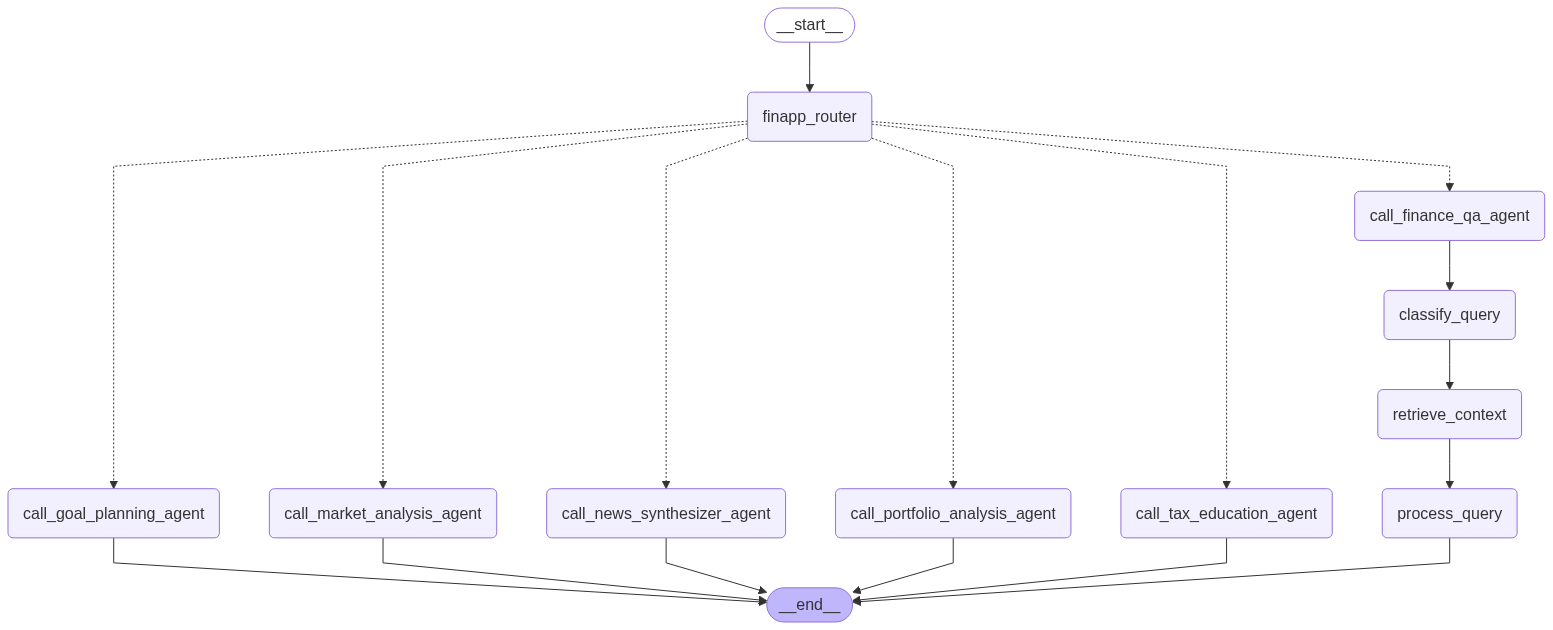

In [16]:
# Build workflow
router_builder = StateGraph(AgentState)

# Add nodes
router_builder.add_node("call_finance_qa_agent", call_finance_qa_agent)

router_builder.add_node("classify_query", classify_query)
router_builder.add_node("retrieve_context", retrieve_context)
router_builder.add_node("process_query", process_query)

router_builder.add_node("call_goal_planning_agent", call_goal_planning_agent)
router_builder.add_node("call_market_analysis_agent", call_market_analysis_agent)
router_builder.add_node("call_news_synthesizer_agent", call_news_synthesizer_agent)
router_builder.add_node("call_portfolio_analysis_agent", call_portfolio_analysis_agent)
router_builder.add_node("call_tax_education_agent", call_tax_education_agent)

router_builder.add_node("finapp_router", finapp_router)

# Add edges to connect nodes
router_builder.add_edge(START, "finapp_router")
router_builder.add_conditional_edges(
    "finapp_router",
    route_decision,
    {  # Name returned by route_decision : Name of next node to visit
        "call_finance_qa_agent": "call_finance_qa_agent",
        "call_goal_planning_agent": "call_goal_planning_agent",
        "call_market_analysis_agent": "call_market_analysis_agent",
        "call_news_synthesizer_agent": "call_news_synthesizer_agent",
        "call_portfolio_analysis_agent": "call_portfolio_analysis_agent",
        "call_tax_education_agent": "call_tax_education_agent",
    },
)

#router_builder.add_edge("call_finance_qa_agent", END)
router_builder.add_edge("call_finance_qa_agent", "classify_query")
router_builder.add_edge("classify_query", "retrieve_context")
router_builder.add_edge("retrieve_context", "process_query")
router_builder.add_edge("process_query", END)

router_builder.add_edge("call_goal_planning_agent", END)
router_builder.add_edge("call_market_analysis_agent", END)
router_builder.add_edge("call_news_synthesizer_agent", END)
router_builder.add_edge("call_portfolio_analysis_agent", END)
router_builder.add_edge("call_tax_education_agent", END)

# compile workflow
router_workflow = router_builder.compile()

# Show the workflow
display(Image(router_workflow.get_graph().draw_mermaid_png()))

In [12]:
#state = router_workflow.invoke({"user_input": "what is portfolio?"})
#print(state["output"])

In [20]:
def get_assistant_content(state: dict) -> list:
    # Ensure hist_messages exists and is a list
    if "hist_messages" not in state or not isinstance(state["hist_messages"], list):
        return []
    
    # Extract content for messages where role is "assistant"
    assistant_contents = [msg["content"] for msg in state["hist_messages"] if msg.get("role") == "assistant"]
    return assistant_contents

state = router_workflow.invoke({"user_input": "what is finance?"})
#response = state['hist_messages']

assistant_messages = get_assistant_content(state)

print(assistant_messages[-1])
#print(response['role'] == 'assistant')

decision: finance
finance
 Finance Q&A Agent: Handles general financial education queries 
straightforward
Finance is a broad field that deals with the management, creation, and study of money, investments, and other financial instruments. It encompasses a variety of activities and disciplines, including:

1. **Personal Finance**: This involves managing individual or household financial activities, such as budgeting, saving, investing, financing major purchases, and planning for retirement.

2. **Corporate Finance**: This focuses on how corporations manage their financial resources, including capital budgeting (deciding on investment projects), capital structure (mix of debt and equity financing), and working capital management (managing short-term assets and liabilities).

3. **Public Finance**: This relates to government finance and involves managing a country's revenue, expenditures, and debt load. It includes budgeting, taxation, and various forms of financial policy intended to in

In [ ]:
#state = router_workflow.invoke({"user_input": "what is goal planning?"})
#print(state["output"])

In [ ]:
#state = router_workflow.invoke({"input": "what is market analysis?"})
#print(state["output"])

In [ ]:
#state = router_workflow.invoke({"user_input": "what is the news?"})
#print(state["output"])

In [ ]:
#state = router_workflow.invoke({"user_input": "Can you provide tax education?"})
#print(state["output"])